# Video features Pigs and Cook

In [1]:
import librosa
import numpy as np
import pandas as pd

from scripts.load_data import check_and_load
from scripts.nested_cv import partition_feature_df
from scripts.extract_audio_features import extract_mfcc

In [2]:
data_path = "../ground_truth_data"
frames_output_dir = "../ground_truth_data/frames"
audio_output_dir = "../ground_truth_data"
annotations_path = "../ground_truth_data"

muppet_files = {
    "Muppets-02-01-01.avi": "GroundTruth_Muppets-02-01-01.csv",
    "Muppets-02-04-04.avi": "GroundTruth_Muppets-02-04-04.csv",
    "Muppets-03-04-03.avi": "GroundTruth_Muppets-03-04-03.csv",
}

annotations, audio_data, frames = check_and_load(data_path, frames_output_dir, audio_output_dir, annotations_path, muppet_files)

Frames and audio are already extracted.
Loading audio segments...
Loaded 3 audio files.
Loaded audio segments for 3 videos.
Loaded frames for 3 videos.
Number of videos with frames: 3
Video 0 has 38681 frames.
Video 1 has 38706 frames.
Video 2 has 38498 frames.


In [3]:
# Define constants
AUDIO_SAMPLING_RATE = 44100
FRAMES_PER_SECOND = 25
# Calculate expected length
samples_per_frame = int(AUDIO_SAMPLING_RATE / FRAMES_PER_SECOND)


## MFCC

In [4]:
mfcc_features  = extract_mfcc(audio_data)

## Log Mel spectrogram

In [8]:
def pad_audio(audio, duration):
    """
    Pad audio with zeros to match the expected length.

    Parameters:
    - audio (ndarray): Audio signal.
    - expected_length (int): Required audio length in samples.

    Returns:
    - ndarray: Padded audio signal.
    """
    req_length = int(AUDIO_SAMPLING_RATE * duration)

    #print(f"exp: {req_length}")
    #print(len(audio))
    if len(audio) < req_length:
        padding = req_length - len(audio)
        audio = np.pad(audio, (0, padding), mode="constant")
        #print(padding)

    return audio

In [11]:
def extract_log_mel_spectrogram(audio_data, n_mels=40, frames_per_second=25):

    log_mel_features = []

    for audio_entry in audio_data:
        try:
            audio = audio_entry['audio']
            sr = audio_entry['sr']
            duration = audio_entry['duration']

            # Pad and normalize audio
            audio = pad_audio(audio, duration)
            audio = librosa.util.normalize(audio)

            # Compute Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(
                y=audio,
                sr=sr,
                n_fft=frames_per_second * 2,  # Assuming 2x frames per second for FFT
                hop_length=frames_per_second,  # Corresponds to one frame per second
                n_mels=n_mels
            )

            # Convert to log scale
            log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

            log_mel_features.append(log_mel_spectrogram)
        except Exception as e:
            print(f"Error processing {audio_entry['audio_file']}: {e}")
            log_mel_features.append(None)

    return log_mel_features


In [15]:
log_mel_features = extract_log_mel_spectrogram(audio_data)

/Users/oleksandra/Desktop/TU/WS 2024/SimilarityModelling/sm_venv/lib/python3.12/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [18]:
len(log_mel_features[0][0])

2729402

## Pitch detection 

# Pigs classification

# Cook classification

In [23]:
gt_211_nointro.loc[gt_211_nointro["Audio_Cook"] == 1]

,Video,Frame_number,Kermit,Pigs,Audio_Pigs,Cook,Audio_Cook,StatlerWaldorf,Audio_StatlerWaldorf,Audio_MissPiggy
28599,211,28973,0,0,0,1,1,0,0,0
28600,211,28974,0,0,0,1,1,0,0,0
28601,211,28975,0,0,0,1,1,0,0,0
28602,211,28976,0,0,0,1,1,0,0,0
28603,211,28977,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
29920,211,30294,0,0,0,1,1,0,0,0
29921,211,30295,0,0,0,1,1,0,0,0
29922,211,30296,0,0,0,1,1,0,0,0
29923,211,30297,0,0,0,1,1,0,0,0


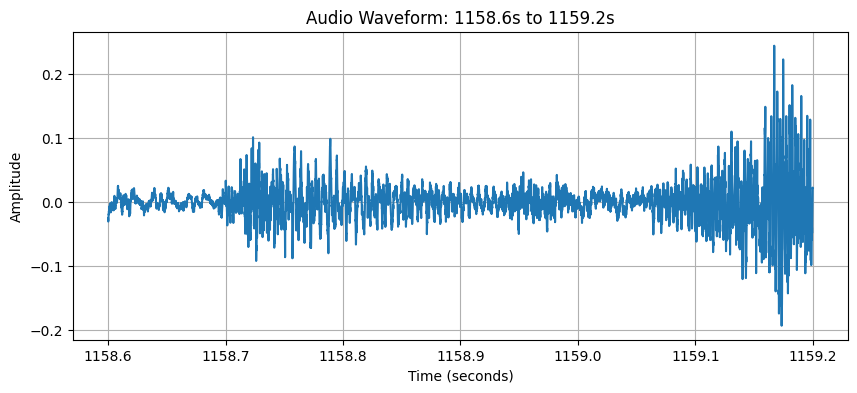

In [24]:
audio_path = "../ground_truth_data/Muppets-02-01-01.wav"

# Frame numbers for the range
frame_start = 28965
frame_end = 28980
fps = 25

# Convert frame numbers to timestamps (in seconds)
timestamp_start = frame_start / fps
timestamp_end = frame_end / fps

# Load audio file using librosa
audio, sr = librosa.load(audio_path, sr=None)  # Use the original sampling rate

# Convert timestamps to samples
start_sample = int(timestamp_start * sr)
end_sample = int(timestamp_end * sr)

# Extract the audio segment
audio_segment = audio[start_sample:end_sample]

# Plot the waveform of the extracted audio segment
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(timestamp_start, timestamp_end, len(audio_segment)), audio_segment)
plt.title(f"Audio Waveform: {timestamp_start}s to {timestamp_end}s")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()